# Homework 3 for Security Analytics 
## Author: Kandarp Khandwala - kkhandw1
---

# Explore network traffic dump

- Task 1: Query function - 2 points
Write a function, given an ip address, output information of all TCP streams that involve this ip address, including stream's starting time, ending time, the other ip address, and stream's size in bytes
  
- Task 2: Plot the query results - 2 points
Use your function from task 1, get all streams of a given ip address (e.g., 192.168.1.64). Then Generate a time series plot of stream size over the starting time.

- Task 3: Restore the content of streams - 2 points
Use the tool tcpflow (http://www.forensicswiki.org/wiki/Tcpflow) to save all stream content to external files. Submit the list of files generated by your tcpflow command.

- Task 4: Explore and analyze the dataset - 4 points
This is an open ended question, intended for you to explore the dataset and implement any kind of analysis and/or visualization on the dataset. Answers to this task will be assessed with considerations of analysis logic/reasoning and creativity.
For example, you could use the pcap data to do some analysis on HTTP traffic, e.g., find out how much HTTP resources 
are successfully fetched along the time. To do so, you can leverage the packet payload data from the pcap. Standard response for successful HTTP requests carry a status code “200 OK”. This status code can be used to filter out the successful HTTP requests.

Let's read the traffic_dump.pcap into tshark, and display frame number and frame length of each captured packet.
* -n: no name resolution
* -r: read from file, not a live capture
* -T fields: use table fields as the output format
* -E header=y: display header
* -e: field to display

In [3]:
!tshark -n -r traffic_dump.pcap -T fields -Eheader=y -e frame.number -e frame.len > frame.len

Let's have a look at the file:

In [4]:
!head -10 frame.len

frame.number	frame.len
1	70
2	70
3	1421
4	70
5	1284
6	70
7	70
8	70
9	78


Use Pandas to read the table into a DataFrame object:

In [5]:
import pandas as pd

In [6]:
df=pd.read_table("frame.len")

Take a look of the data frame.

In [7]:
df

,frame.number,frame.len
0,1,70
1,2,70
2,3,1421
3,4,70
4,5,1284
5,6,70
6,7,70
7,8,70
8,9,78
9,10,78


Some statistics about the frame length:

In [8]:
df["frame.len"].describe()

count    94410.000000
mean       579.072524
std        625.671800
min         42.000000
25%         70.000000
50%         86.000000
75%       1466.000000
max       1466.000000
Name: frame.len, dtype: float64

The min and max are compliant with Ethernet specifications.

## Plotting

For a better overview, we plot the frame length over time.

We initialise IPython to show inline graphics:

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Set a figure size in inches:

In [10]:
figsize(10,6)

Pandas automatically uses Matplotlib for plotting. We plot with small dots and an alpha channel of 0.2:

Text(0.5,0,'frame number')

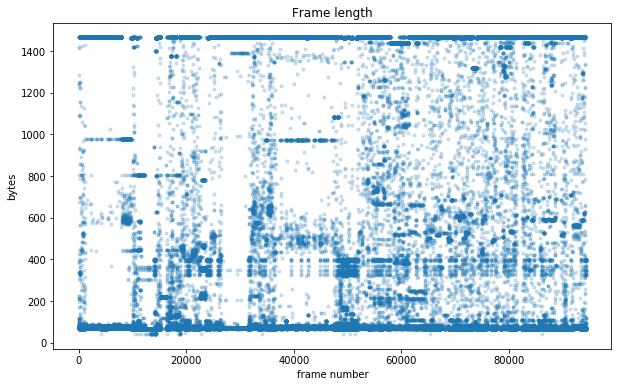

In [11]:
df["frame.len"].plot(style=".", alpha=0.2)
title("Frame length")
ylabel("bytes")
xlabel("frame number")

So there are always lots of small packets (< 100 bytes) and lots of large packets (> 1400 bytes). Some bursts of packets with other sizes (around 400 bytes, 1000 bytes, etc.) can be clearly seen.

### A nice Python function to help read data

Here is a convenient helper function that reads the given fields into a Pandas DataFrame:

In [13]:
import subprocess
import datetime
import pandas as pd

def mydateparser(time_in_secs):    
    return datetime.datetime.fromtimestamp(float(time_in_secs))


def read_traffic(filename, fields=[], display_filter="", 
              timeseries=False, strict=False):
    """ Read PCAP file into Pandas DataFrame object. 
    Uses tshark command-line tool from Wireshark.

    filename:       Name or full path of the PCAP file to read
    fields:         List of fields to include as columns
    display_filter: Additional filter to restrict frames
    strict:         Only include frames that contain all given fields 
                    (Default: false)
    timeseries:     Create DatetimeIndex from frame.time_epoch 
                    (Default: false)

    Syntax for fields and display_filter is specified in
    Wireshark's Display Filter Reference:
 
      http://www.wireshark.org/docs/dfref/
    """
    if timeseries:
        fields = ["frame.time_epoch"] + fields
    fieldspec = " ".join("-e %s" % f for f in fields)

    display_filters = fields if strict else []
    if display_filter:
        display_filters.append(display_filters)
    filterspec = "-Y '%s'" % " and ".join(f for f in display_filters)

    options = "-r %s -n -T fields -Eheader=y" % filename
    cmd = "tshark %s %s %s" % (options, filterspec, fieldspec)
    print(cmd)
    proc = subprocess.Popen(cmd, shell = True, 
                                 stdout=subprocess.PIPE)
    if timeseries:
        df = pd.read_table(proc.stdout, 
                        index_col = "frame.time_epoch", 
                        parse_dates=True, 
                        date_parser=mydateparser)
    else:
        df = pd.read_table(proc.stdout)
    return df

## Bandwidth Usage

We want to know how much bandwidth is used every second. To do that, we need to sum up the frame lengths for every second.

First use our helper function to read the traffic trace into a DataFrame:

In [14]:
framelen=read_traffic("traffic_dump.pcap", ["frame.len"], timeseries=True)
#framelen

tshark -r traffic_dump.pcap -n -T fields -Eheader=y -Y '' -e frame.time_epoch -e frame.len


Then we re-sample the timeseries into buckets of 1 second, summing over the lengths of all frames that were captured in that second:

In [15]:
#bytes_per_second=framelen.resample("S", how="sum")
bytes_per_second=framelen.resample("S").sum()

Here are the first 5 rows. We get NaN for those timestamps where no frames were captured:

In [16]:
bytes_per_second.head()

,frame.len
frame.time_epoch,
2008-07-21 21:51:07,20729
2008-07-21 21:51:08,8426
2008-07-21 21:51:09,13565
2008-07-21 21:51:10,0
2008-07-21 21:51:11,0


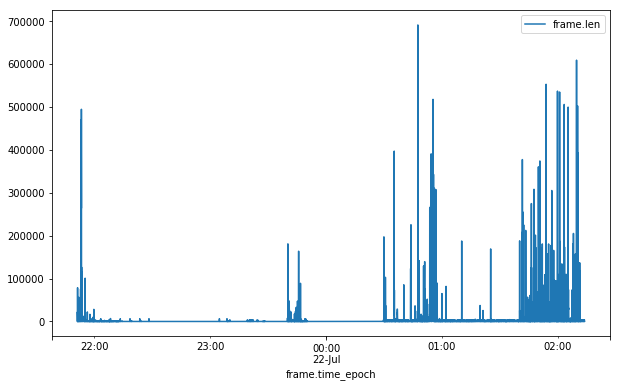

In [17]:
bytes_per_second.plot()

## Analyze the trace at TCP level

Let's try to replicate the TCP Time-Sequence Graph

In [18]:
fields=["tcp.stream", "ip.src", "ip.dst", "tcp.seq", "tcp.ack", "tcp.window_size", "tcp.len"]
ts=read_traffic("traffic_dump.pcap", fields, timeseries=True, strict=True)
ts

tshark -r traffic_dump.pcap -n -T fields -Eheader=y -Y 'frame.time_epoch and tcp.stream and ip.src and ip.dst and tcp.seq and tcp.ack and tcp.window_size and tcp.len' -e frame.time_epoch -e tcp.stream -e ip.src -e ip.dst -e tcp.seq -e tcp.ack -e tcp.window_size -e tcp.len


,tcp.stream,ip.src,ip.dst,tcp.seq,tcp.ack,tcp.window_size,tcp.len
frame.time_epoch,,,,,,,
2008-07-21 21:51:07.095278,0,192.168.1.64,74.125.19.83,1,1,65535,0
2008-07-21 21:51:07.103728,0,74.125.19.83,192.168.1.64,1,2,431,0
2008-07-21 21:51:07.114897,1,192.168.1.64,74.125.19.19,1,1,65535,1351
2008-07-21 21:51:07.139448,1,74.125.19.19,192.168.1.64,1,1352,393,0
2008-07-21 21:51:07.319680,1,74.125.19.19,192.168.1.64,1,1352,393,1214
2008-07-21 21:51:07.321990,1,192.168.1.64,74.125.19.19,1352,1215,65460,0
2008-07-21 21:51:07.326517,1,192.168.1.64,74.125.19.19,1352,1215,65535,0
2008-07-21 21:51:07.335554,1,74.125.19.19,192.168.1.64,1215,1353,393,0
2008-07-21 21:51:07.423663,2,192.168.1.64,74.125.19.103,0,0,65535,0


Now we have to select a TCP stream to analyse. As an example, we just pick stream number 10:

In [19]:
stream=ts[ts["tcp.stream"] == 10]
stream

,tcp.stream,ip.src,ip.dst,tcp.seq,tcp.ack,tcp.window_size,tcp.len
frame.time_epoch,,,,,,,
2008-07-21 21:51:19.259731,10,192.168.1.64,209.3.183.2,0,0,65535,0
2008-07-21 21:51:19.340181,10,209.3.183.2,192.168.1.64,0,1,5840,0
2008-07-21 21:51:19.344787,10,192.168.1.64,209.3.183.2,1,1,65535,0
2008-07-21 21:51:19.351712,10,192.168.1.64,209.3.183.2,1,1,65535,268
2008-07-21 21:51:19.440658,10,209.3.183.2,192.168.1.64,1,269,6432,0
2008-07-21 21:51:19.441668,10,209.3.183.2,192.168.1.64,1,269,6432,641
2008-07-21 21:51:19.450322,10,192.168.1.64,209.3.183.2,269,642,65535,0
2008-07-21 21:51:19.452424,10,192.168.1.64,209.3.183.2,269,642,65535,274
2008-07-21 21:51:19.536225,10,209.3.183.2,192.168.1.64,642,543,7504,1165


Add a column that shows who sent the packet (client or server). 

The fancy lambda expression is a function that distinguishes between the client and the server side of the stream by comparing the source IP address with the source IP address of the first packet in the stream (for TCP steams that should have been sent by the client).

In [20]:
stream = stream.copy()
stream["type"] = stream.apply(lambda x: "client" if x["ip.src"] == stream.iloc[0]["ip.src"] else "server", axis=1)

In [21]:
#print stream.to_string()
stream

,tcp.stream,ip.src,ip.dst,tcp.seq,tcp.ack,tcp.window_size,tcp.len,type
frame.time_epoch,,,,,,,,
2008-07-21 21:51:19.259731,10,192.168.1.64,209.3.183.2,0,0,65535,0,client
2008-07-21 21:51:19.340181,10,209.3.183.2,192.168.1.64,0,1,5840,0,server
2008-07-21 21:51:19.344787,10,192.168.1.64,209.3.183.2,1,1,65535,0,client
2008-07-21 21:51:19.351712,10,192.168.1.64,209.3.183.2,1,1,65535,268,client
2008-07-21 21:51:19.440658,10,209.3.183.2,192.168.1.64,1,269,6432,0,server
2008-07-21 21:51:19.441668,10,209.3.183.2,192.168.1.64,1,269,6432,641,server
2008-07-21 21:51:19.450322,10,192.168.1.64,209.3.183.2,269,642,65535,0,client
2008-07-21 21:51:19.452424,10,192.168.1.64,209.3.183.2,269,642,65535,274,client
2008-07-21 21:51:19.536225,10,209.3.183.2,192.168.1.64,642,543,7504,1165,server


In [22]:
client_stream=stream[stream.type == "client"]
client_stream

,tcp.stream,ip.src,ip.dst,tcp.seq,tcp.ack,tcp.window_size,tcp.len,type
frame.time_epoch,,,,,,,,
2008-07-21 21:51:19.259731,10,192.168.1.64,209.3.183.2,0,0,65535,0,client
2008-07-21 21:51:19.344787,10,192.168.1.64,209.3.183.2,1,1,65535,0,client
2008-07-21 21:51:19.351712,10,192.168.1.64,209.3.183.2,1,1,65535,268,client
2008-07-21 21:51:19.450322,10,192.168.1.64,209.3.183.2,269,642,65535,0,client
2008-07-21 21:51:19.452424,10,192.168.1.64,209.3.183.2,269,642,65535,274,client
2008-07-21 21:51:19.538457,10,192.168.1.64,209.3.183.2,543,1807,65535,0,client
2008-07-21 21:51:19.540394,10,192.168.1.64,209.3.183.2,543,1807,65535,266,client
2008-07-21 21:51:19.631786,10,192.168.1.64,209.3.183.2,809,3001,65535,0,client
2008-07-21 21:51:19.632254,10,192.168.1.64,209.3.183.2,809,3001,65535,268,client


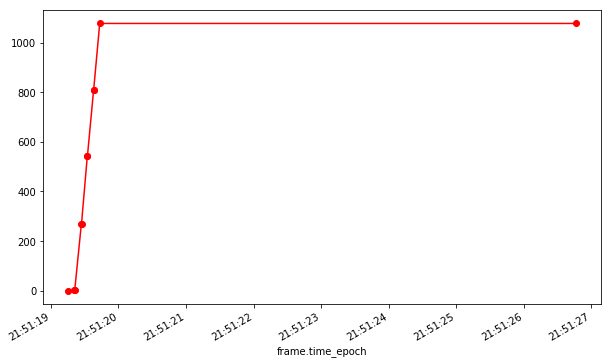

In [23]:
client_stream["tcp.seq"].plot(style="r-o")

Notice that the x-axis shows the real timestamps.

For comparison, change the x-axis to be the packet number in the stream:

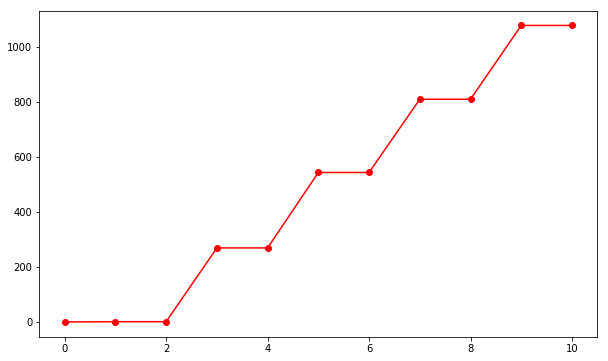

In [24]:
client_stream.index = arange(len(client_stream))
client_stream["tcp.seq"].plot(style="r-o")

Looks different of course.

## Bytes per stream

In [25]:
per_stream=ts.groupby("tcp.stream")
per_stream.head()

,tcp.stream,ip.src,ip.dst,tcp.seq,tcp.ack,tcp.window_size,tcp.len
frame.time_epoch,,,,,,,
2008-07-21 21:51:07.095278,0,192.168.1.64,74.125.19.83,1,1,65535,0
2008-07-21 21:51:07.103728,0,74.125.19.83,192.168.1.64,1,2,431,0
2008-07-21 21:51:07.114897,1,192.168.1.64,74.125.19.19,1,1,65535,1351
2008-07-21 21:51:07.139448,1,74.125.19.19,192.168.1.64,1,1352,393,0
2008-07-21 21:51:07.319680,1,74.125.19.19,192.168.1.64,1,1352,393,1214
2008-07-21 21:51:07.321990,1,192.168.1.64,74.125.19.19,1352,1215,65460,0
2008-07-21 21:51:07.326517,1,192.168.1.64,74.125.19.19,1352,1215,65535,0
2008-07-21 21:51:07.423663,2,192.168.1.64,74.125.19.103,0,0,65535,0
2008-07-21 21:51:07.432370,2,74.125.19.103,192.168.1.64,0,1,5672,0


In [26]:
bytes_per_stream = per_stream["tcp.len"].sum()
bytes_per_stream.head()

tcp.stream
0       0
1    2565
2    5158
3    8266
4    5017
Name: tcp.len, dtype: int64

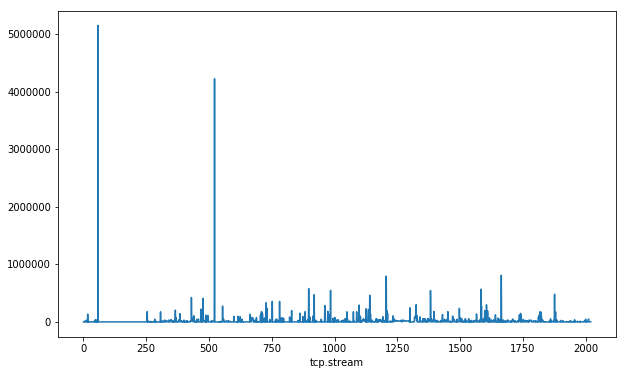

In [27]:
bytes_per_stream.plot()

In [28]:
bytes_per_stream.max()

5150771

In [29]:
biggest_stream=bytes_per_stream.idxmax()
biggest_stream

58

In [30]:
bytes_per_stream.loc[biggest_stream]

5150771